In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from geoai.data.image import Image

In [3]:
from osgeo import gdal
import geopandas as gpd

from shapely.geometry import box
from shapely.geometry import Polygon

/home/sandeep/miniconda3/envs/geoai/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_2803404/663324026.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are usi

In [4]:
ds = gdal.Open('/home/sandeep/workspace/data/human-settlements/S2A_MSIL2A_20230102T054231_N0509_R005_T43QBB_20230102T083154.SAFE/MTD_MSIL2A.xml')

In [5]:
ds_10m = gdal.Open(ds.GetSubDatasets()[0][0])

In [6]:
ds_RGB = gdal.Open(ds.GetSubDatasets()[-1][0])

In [7]:
im = Image.from_gdal(ds_RGB)

In [8]:
im.crs

<Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

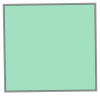

In [9]:
im.bbox_4326

In [10]:
gdf = gpd.read_feather('/home/sandeep/workspace/data/building-footprints/3bf_buildings.feather')
len(gdf)

9207491

In [11]:
gpd.options.use_pygeos

True

In [12]:
gdf_prj = gdf[gdf.intersects(im.bbox_4326)].to_crs(im.crs)[['geometry']]
del gdf
len(gdf_prj)

2093126

In [13]:
gdf_prj.head()

,geometry
1,"POLYGON ((275252.285 2122862.672, 275251.482 2..."
13,"POLYGON ((293394.940 2186376.156, 293394.940 2..."
14,"POLYGON ((287684.613 2127012.809, 287673.705 2..."
19,"POLYGON ((299138.128 2133742.850, 299137.966 2..."
28,"POLYGON ((293776.167 2097188.657, 293773.514 2..."


In [14]:


# gdf_prj = gdf_prj[gdf_prj.intersects(box(290775, 2126076, 312261, 2140126))]
# gdf_prj.head()

In [15]:
buffer_distance = 25 # meters


# Buffer to convert buildings to clusters
gdf_prj['geometry'] = gdf_prj.buffer(buffer_distance)

In [16]:
# Flatten out clusters
gdf_cluster = gdf_prj.dissolve().explode(index_parts=False).reset_index(drop=True)
del gdf_prj
len(gdf_cluster)

50327

In [17]:
# # Remove stray buildings not visible in Sentinel
# gdf_cluster = gdf_cluster[gdf_cluster.buffer(-buffer_distance).area > (buffer_distance*buffer_distance*4)]
# len(gdf_cluster)

In [18]:
# Remove Stray holes
def remove_holes(geom):
    holes = []
    for hole in geom.interiors:
        if Polygon(hole).area > buffer_distance*buffer_distance*4:
            holes.append(hole)
    return Polygon(geom.exterior, holes)

gdf_cluster['geometry'] = gdf_cluster['geometry'].apply(remove_holes)

In [19]:
# Reverse buffer
gdf_cluster = gdf_cluster.explode(index_parts=False).reset_index(drop=True)
gdf_cluster['geometry'] = gdf_cluster.buffer(-buffer_distance/2)
len(gdf_cluster)

50327

In [20]:
# Remove stray buildings not visible in Sentinel
gdf_cluster = gdf_cluster.explode(index_parts=False).reset_index(drop=True)
gdf_cluster = gdf_cluster[gdf_cluster.buffer(-buffer_distance).area > (buffer_distance*buffer_distance*4)]
len(gdf_cluster)

3185

In [21]:
gdf_cluster.head()

,geometry
2,"POLYGON ((257027.555 2192167.455, 257027.560 2..."
4,"POLYGON ((256624.256 2192786.587, 256624.215 2..."
25,"POLYGON ((254304.582 2194890.402, 254304.695 2..."
26,"POLYGON ((255011.742 2194526.224, 255012.578 2..."
30,"POLYGON ((255191.554 2193985.383, 255191.691 2..."


In [22]:
gdf_cluster.to_feather('/home/sandeep/workspace/data/human-settlements/bf_cluster_S2A_MSIL2A_20230102T054231_N0509_R005_T43QBB_20230102T083154.feather')

In [23]:
gdf_cluster.to_file('/home/sandeep/workspace/data/human-settlements/bf_cluster_S2A_MSIL2A_20230102T054231_N0509_R005_T43QBB_20230102T083154.gpkg')